In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import wandb
from sklearn.utils.class_weight import compute_class_weight
import os

c:\Users\filip\dev\malware-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
dataset_path = "./data/malicious_phish.csv"
output_dir = "./codebert_finetuned_malicious_urls"

# Load dataset
df = pd.read_csv(dataset_path)

# Verify columns
required_columns = ["url", "type"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Dataset must contain columns: {required_columns}")


df["llm_input"] = df["url"]

# Map labels
label_map = {"benign": 0, "phishing": 1, "defacement": 2, "malware": 3}
df["label"] = df["type"].map(label_map)

# Verify labels
if df["label"].isnull().any():
    raise ValueError("Invalid labels detected in dataset")

In [3]:
# Split dataset: 80% train, 10% validation, 10% test
train_val, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])
train, val = train_test_split(train_val, test_size=0.1111, random_state=42, stratify=train_val['label'])

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train[['llm_input', 'label']])
val_dataset = Dataset.from_pandas(val[['llm_input', 'label']])
test_dataset = Dataset.from_pandas(test[['llm_input', 'label']])

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples['llm_input'],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 65120/65120 [00:06<00:00, 9520.00 examples/s]


In [4]:
# Initialize WandB
wandb.init(project="codebert-malicious-urls", reinit=True)

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base",
    num_labels=4,  # 4 classes: benign, phishing, defacement, malware
)
model.to(device)

# Compute class weights
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train["label"]), y=train["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

wandb: Currently logged in as: loyd (loyd-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti SUPER


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Define compute_metrics for multiclass
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)
    # Log per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = (
        precision_recall_fscore_support(labels, preds, average=None)
    )
    class_names = ["Benign", "Phishing", "Defacement", "Malware"]
    per_class_metrics = {
        f"precision_{class_names[i]}": precision_per_class[i]
        for i in range(len(class_names))
    }
    per_class_metrics.update(
        {
            f"recall_{class_names[i]}": recall_per_class[i]
            for i in range(len(class_names))
        }
    )
    per_class_metrics.update(
        {f"f1_{class_names[i]}": f1_per_class[i] for i in range(len(class_names))}
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        **per_class_metrics,
    }


# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    seed=42,
    fp16=True,
    dataloader_num_workers=4,
    dataloader_drop_last=True,
    report_to="wandb",
)

# Log hyperparameters
wandb.config.update(training_args)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [6]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Benign,Precision Phishing,Precision Defacement,Precision Malware,Recall Benign,Recall Phishing,Recall Defacement,Recall Malware,F1 Benign,F1 Phishing,F1 Defacement,F1 Malware
1,0.056300,0.049226,0.986403,0.985252,0.974566,0.979794,0.988606,0.968843,0.991150,0.992407,0.995700,0.938669,0.998963,0.964934,0.992140,0.953517,0.995041,0.978478
2,0.036300,0.049503,0.988692,0.986570,0.980499,0.983496,0.991775,0.967502,0.993913,0.993088,0.994835,0.955676,0.999170,0.972316,0.993303,0.961553,0.996535,0.982592
3,0.040200,0.048531,0.988877,0.985319,0.981862,0.983569,0.993086,0.963267,0.994633,0.990291,0.993713,0.961628,0.999481,0.972624,0.993400,0.962447,0.997051,0.981378


TrainOutput(global_step=48837, training_loss=0.05373248319567076, metrics={'train_runtime': 12391.0168, 'train_samples_per_second': 126.13, 'train_steps_per_second': 3.941, 'total_flos': 4.1119313128154726e+17, 'train_loss': 0.05373248319567076, 'epoch': 3.0})

In [7]:

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print("Test set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Log test results to WandB
wandb.log({f"test_{metric}": value for metric, value in test_results.items()})

# Save model and tokenizer
print(f"\nSaving model to {output_dir}")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Evaluating on test set...


Test set results:
eval_loss: 0.0490
eval_accuracy: 0.9886
eval_precision: 0.9860
eval_recall: 0.9810
eval_f1: 0.9834
eval_precision_Benign: 0.9926
eval_precision_Phishing: 0.9611
eval_precision_Defacement: 0.9955
eval_precision_Malware: 0.9946
eval_recall_Benign: 0.9937
eval_recall_Phishing: 0.9610
eval_recall_Defacement: 0.9991
eval_recall_Malware: 0.9702
eval_f1_Benign: 0.9931
eval_f1_Phishing: 0.9611
eval_f1_Defacement: 0.9973
eval_f1_Malware: 0.9823
eval_runtime: 133.1391
eval_samples_per_second: 489.1120
eval_steps_per_second: 15.2850
epoch: 3.0000

Saving model to ./codebert_finetuned_malicious_urls


('./codebert_finetuned_malicious_urls\\tokenizer_config.json',
 './codebert_finetuned_malicious_urls\\special_tokens_map.json',
 './codebert_finetuned_malicious_urls\\vocab.json',
 './codebert_finetuned_malicious_urls\\merges.txt',
 './codebert_finetuned_malicious_urls\\added_tokens.json',
 './codebert_finetuned_malicious_urls\\tokenizer.json')

In [ ]:
# Log confusion matrix
from sklearn.metrics import confusion_matrix
preds = trainer.predict(test_dataset).predictions.argmax(-1)

In [15]:
# Check for unexpected labels and convert tensors to integers
labels = [
    label.item() if torch.is_tensor(label) else label for label in test_dataset["label"]
]  # Convert tensors to integers
unique_labels = set(labels)
expected_labels = set(range(4))
if not unique_labels.issubset(expected_labels):
    print("Unexpected labels found:", unique_labels - expected_labels)
    # Optionally, filter out unexpected labels
    filtered = [(p, l) for p, l in zip(preds, labels) if l in expected_labels]
    preds, labels = zip(*filtered)
    preds = list(preds)
    labels = list(labels)

# Now log the confusion matrix
wandb.log(
    {
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=labels,
            preds=preds,
            class_names=["Benign", "Phishing", "Defacement", "Malware"],
        )
    }
)

# Example inference
sample_input = "Method: GET\nURL: /phish.com/login\nContent: None"
sample_tokenized = tokenizer(
    sample_input, return_tensors="pt", max_length=512, truncation=True, padding=True
)
model.eval()
with torch.no_grad():
    sample_tokenized = {k: v.to(device) for k, v in sample_tokenized.items()}
    outputs = model(**sample_tokenized)
    predicted_label = outputs.logits.argmax().item()
print(f"\nSample input: {sample_input}")
print(
    f"Predicted label: {['Benign', 'Phishing', 'Defacement', 'Malware'][predicted_label]}"
)

# Log sample prediction
wandb.log(
    {
        "sample_input": sample_input,
        "predicted_label": ["Benign", "Phishing", "Defacement", "Malware"][
            predicted_label
        ],
    }
)

# Finish WandB run
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



Sample input: Method: GET
URL: /phish.com/login
Content: None
Predicted label: Benign


eval/accuracy,▁▇█▇
eval/f1,▁███
eval/f1_Benign,▁▇█▇
eval/f1_Defacement,▁▆▇█
eval/f1_Malware,▁█▆▇
eval/f1_Phishing,▁▇█▇
eval/loss,▆█▁▅
eval/precision,▁█▁▅
eval/precision_Benign,▁▆█▇
eval/precision_Defacement,▁▅▇█
eval/precision_Malware,▄▆▁█


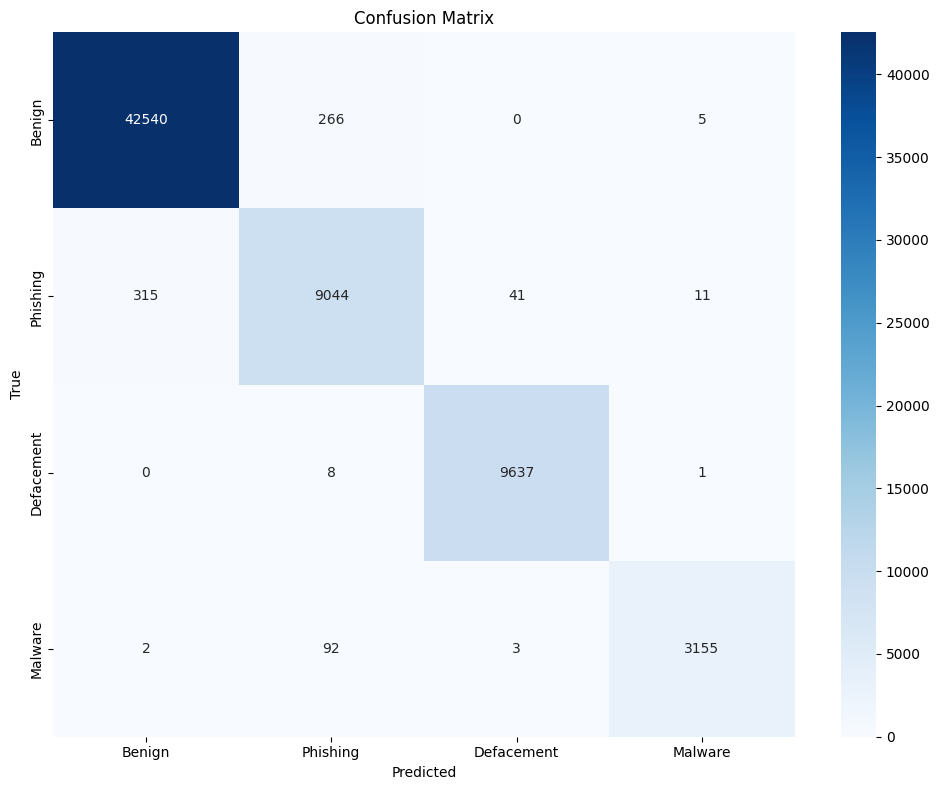

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = [
    label.item() if torch.is_tensor(label) else label for label in test_dataset["label"]
]

# Create confusion matrix
cm = confusion_matrix(labels, preds)

# Create figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    cm,
    annot=True,  # Show numbers in cells
    fmt="d",  # Format as integers
    cmap="Blues",  # Color scheme
    xticklabels=["Benign", "Phishing", "Defacement", "Malware"],
    yticklabels=["Benign", "Phishing", "Defacement", "Malware"],
)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()